In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
import keras
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

from ml_model_forward import ForwardTMMModel
# Read the CSV file
data = pd.read_csv("R.csv")

2023-06-20 01:05:10.135421: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 01:05:10.223801: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 01:05:10.224951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 01:05:12.052921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

labels = data.copy()

feature_headings = [
    "d1","d2","d3","d4","d5","d6","First Layer","Second Layer"
]

output_values = labels[feature_headings]
input_features = labels[[c for c in labels.columns if c not in feature_headings]]
label_encoder = LabelEncoder()

output_values["First Layer"] = label_encoder.fit_transform(output_values["First Layer"])
output_values["Second Layer"] = label_encoder.transform(output_values["Second Layer"])

unique_materials = pd.unique(data[['First Layer', 'Second Layer']].values.ravel())


num_materials = len(unique_materials)
num_wavelengths = 351

input_train, input_test, output_train, output_test = train_test_split(input_features, output_values, test_size=0.2, random_state=42)
input_train, input_val, output_train, output_val = train_test_split(input_train, output_train, test_size=0.2, random_state=42)

/tmp/ipykernel_5715/1402317043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_values["First Layer"] = label_encoder.fit_transform(output_values["First Layer"])
/tmp/ipykernel_5715/1402317043.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_values["Second Layer"] = label_encoder.transform(output_values["Second Layer"])


In [3]:
i = Input(num_wavelengths,)

dl1 = Dense(num_wavelengths, activation="PReLU", input_shape=(num_wavelengths,))(i)

m1dl2 = Dense(256, activation="PReLU")(dl1)
m2dl2 = Dense(256, activation="PReLU")(dl1)
tdl2 = Dense(256, activation="PReLU")(dl1)

concatenated_input = Concatenate()([m1dl2, m2dl2, tdl2])

common_layer = Dense(500)(concatenated_input)

m1dl3 = Dense(128, activation="PReLU")(common_layer)
m2dl3 = Dense(128, activation="PReLU")(common_layer)
tdl3 = Dense(128, activation="PReLU")(common_layer)

out1 = Dense(num_materials, "softmax", name="first_layer")(m1dl3)
out2 = Dense(num_materials, "softmax", name="second_layer")(m2dl3)

material1 = Concatenate()([tdl3,out1])
material2 = Concatenate()([tdl3,out2])
t1 = Dense(1, "relu", name="t1")(material1)
t2 = Dense(1, "relu", name="t2")(material2)
t3 = Dense(1, "relu", name="t3")(material1)
t4 = Dense(1, "relu", name="t4")(material2)
t5 = Dense(1, "relu", name="t5")(material1)
t6 = Dense(1, "relu", name="t6")(material2)

classifier = Model(inputs=i, outputs=[out1,out2,t1,t2,t3,t4,t5,t6])
classifier.compile(
    optimizer="adam",
    loss={
        "first_layer": keras.losses.SparseCategoricalCrossentropy(),
        "second_layer": keras.losses.SparseCategoricalCrossentropy(),
        "t1": "mean_squared_error",
        "t2": "mean_squared_error",
        "t3": "mean_squared_error",
        "t4": "mean_squared_error",
        "t5": "mean_squared_error",
        "t6": "mean_squared_error",
    },
    metrics={
        "first_layer": tf.metrics.SparseCategoricalAccuracy("acc1"),
        "second_layer": tf.metrics.SparseCategoricalAccuracy("acc2"),
        "t1": "accuracy",
        "t2": "accuracy",
        "t3": "accuracy",
        "t4": "accuracy",
        "t5": "accuracy",
        "t6": "accuracy",
    }
)

In [4]:
classifier.fit(
    input_train,
    {
        "first_layer": output_train["First Layer"],
        "second_layer": output_train["Second Layer"],
        "t1": output_train["d1"],
        "t2": output_train["d2"],
        "t3": output_train["d3"],
        "t4": output_train["d4"],
        "t5": output_train["d5"],
        "t6": output_train["d6"],
    },
    epochs=10,
    validation_data=(
        input_val,
        {
            "first_layer": output_val["First Layer"],
            "second_layer": output_val["Second Layer"],
            "t1": output_val["d1"],
            "t2": output_val["d2"],
            "t3": output_val["d3"],
            "t4": output_val["d4"],
            "t5": output_val["d5"],
            "t6": output_val["d6"],
        }
    ),
    batch_size=32
)

Epoch 1/10
600/600 [==============================] - 29s 32ms/step - loss: 3213.3271 - first_layer_loss: 3.5272 - second_layer_loss: 3.6808 - t1_loss: 330.9426 - t2_loss: 325.9100 - t3_loss: 1528.6875 - t4_loss: 330.7533 - t5_loss: 359.5565 - t6_loss: 330.2702 - first_layer_acc1: 0.0501 - second_layer_acc2: 0.0319 - t1_accuracy: 0.0000e+00 - t2_accuracy: 0.0000e+00 - t3_accuracy: 0.0000e+00 - t4_accuracy: 0.0000e+00 - t5_accuracy: 0.0000e+00 - t6_accuracy: 0.0000e+00 - val_loss: 2941.3384 - val_first_layer_loss: 3.2730 - val_second_layer_loss: 3.4650 - val_t1_loss: 292.0118 - val_t2_loss: 294.8276 - val_t3_loss: 1482.0834 - val_t4_loss: 282.0858 - val_t5_loss: 286.7247 - val_t6_loss: 296.8671 - val_first_layer_acc1: 0.0792 - val_second_layer_acc2: 0.0344 - val_t1_accuracy: 0.0000e+00 - val_t2_accuracy: 0.0000e+00 - val_t3_accuracy: 0.0000e+00 - val_t4_accuracy: 0.0000e+00 - val_t5_accuracy: 0.0000e+00 - val_t6_accuracy: 0.0000e+00
Epoch 2/10
600/600 [==============================] - 

Epoch 10/10
600/600 [==============================] - 19s 32ms/step - loss: 1683.6908 - first_layer_loss: 3.0454 - second_layer_loss: 3.1779 - t1_loss: 277.5498 - t2_loss: 276.9469 - t3_loss: 280.1049 - t4_loss: 280.0721 - t5_loss: 281.5400 - t6_loss: 281.2544 - first_layer_acc1: 0.1036 - second_layer_acc2: 0.0851 - t1_accuracy: 0.0000e+00 - t2_accuracy: 0.0000e+00 - t3_accuracy: 0.0000e+00 - t4_accuracy: 0.0000e+00 - t5_accuracy: 0.0000e+00 - t6_accuracy: 0.0000e+00 - val_loss: 1663.6813 - val_first_layer_loss: 2.9844 - val_second_layer_loss: 3.1404 - val_t1_loss: 271.0372 - val_t2_loss: 277.7765 - val_t3_loss: 277.9718 - val_t4_loss: 273.8821 - val_t5_loss: 280.4547 - val_t6_loss: 276.4341 - val_first_layer_acc1: 0.1333 - val_second_layer_acc2: 0.0967 - val_t1_accuracy: 0.0000e+00 - val_t2_accuracy: 0.0000e+00 - val_t3_accuracy: 0.0000e+00 - val_t4_accuracy: 0.0000e+00 - val_t5_accuracy: 0.0000e+00 - val_t6_accuracy: 0.0000e+00


In [20]:
forward_model = ForwardTMMModel(serialised_model_path="forward_model.mdlsav")
print(forward_model.is_trained)

True


In [23]:
index = random.randint(0, len(input_test) - 1)
input_sample = input_test.iloc[[index]]
output_sample = output_test.iloc[[index]]
mat_predict = classifier.predict([input_sample])
pred = label_encoder.inverse_transform([np.argmax(mat_predict[0]), np.argmax(mat_predict[1])])
act = label_encoder.inverse_transform([output_sample["First Layer"], output_sample["Second Layer"]])

print(f"model predicted: {pred}")
print(f"actual combination: {act}")

reference_waveform = input_sample
predicted_waveform = forward_model.predict_one([elem[0,0] for elem in mat_predict[:6]], pred)

1/1 [==============================] - 0s 37ms/step
model predicted: ['Au' 'Pt']
actual combination: ['ZrO2' 'Mn']
1/1 [==============================] - 0s 27ms/step


/home/clk/repos/l2-transfer-matrix-method/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


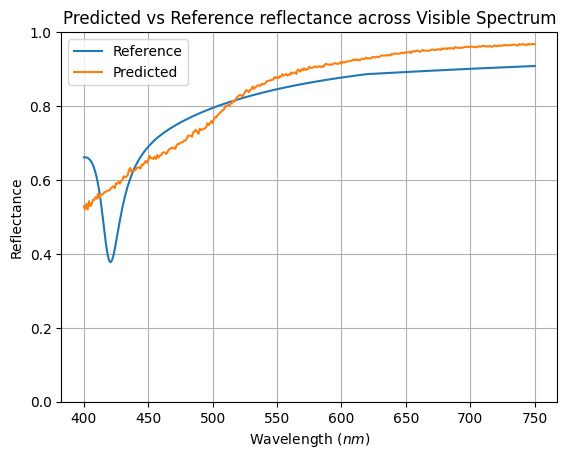

In [24]:
import matplotlib.pyplot as plt

x = np.arange(400,751)

plt.plot(x, reference_waveform.values.T, label="Reference")
plt.plot(x, predicted_waveform.values.T, label="Predicted")

plt.ylim((0,1))
plt.xlabel(r"Wavelength ($nm$)")
plt.ylabel("Reflectance")
plt.grid()
plt.title("Predicted vs Reference reflectance across Visible Spectrum")

plt.legend()